# 🔍 Quick Phase 1 Data Exploration
## Let's see what enhancements we can add!

**Goal:** Quickly discover what's possible with your data

**Run each cell and see the magic! ✨**

---

## Part 1: Load Data and Check Contents

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

print("✅ Libraries loaded!")

✅ Libraries loaded!


In [2]:
# Load your cleaned data
df = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_cleaned.parquet')

print("=" * 80)
print("📦 YOUR DATA INVENTORY")
print("=" * 80)

print(f"\n📊 Dataset size: {len(df):,} records")
print(f"📅 Time range: {df['time'].min()} to {df['time'].max()}")
print(f"⏱️  Duration: {(df['time'].max() - df['time'].min()).days} days")

print(f"\n📋 What's inside:")
for col in df.columns:
    print(f"  ✓ {col}")

print(f"\n👀 Preview:")
df.head()

📦 YOUR DATA INVENTORY

📊 Dataset size: 15,859 records
📅 Time range: 2015-01-01 00:00:00 to 2025-11-08 12:00:00
⏱️  Duration: 3964 days

📋 What's inside:
  ✓ time
  ✓ hs
  ✓ tp
  ✓ dir
  ✓ wind_u
  ✓ wind_v
  ✓ wind_speed
  ✓ month
  ✓ month_name

👀 Preview:


,time,hs,tp,dir,wind_u,wind_v,wind_speed,month,month_name
0,2015-01-01 00:00:00,1.788754,5.521828,201.499268,5.959814,10.596545,12.157556,1,Jan
1,2015-01-01 06:00:00,1.297573,5.639015,202.063553,3.951309,8.450397,9.328561,1,Jan
2,2015-01-01 12:00:00,1.801332,5.402687,188.969910,3.231293,11.774301,12.209644,1,Jan
3,2015-01-01 18:00:00,2.500455,6.356300,198.457153,8.083596,11.590133,14.130666,1,Jan
4,2015-01-02 00:00:00,3.188416,6.959816,234.631287,15.009109,4.351538,15.627195,1,Jan


---
## Part 2: Enhancement #1 - Weather Windows 🪟

**Question:** How many consecutive workable days can we expect?

In [3]:
print("=" * 80)
print("🪟 WEATHER WINDOWS ANALYSIS")
print("=" * 80)

# Define operation (change these if you want!)
max_hs = 2.5
max_wind = 15.0

print(f"\nOperation: Crane Heavy Lift")
print(f"Limits: Hs < {max_hs}m, Wind < {max_wind}m/s\n")

# Sort by time
df_sorted = df.sort_values('time').reset_index(drop=True)

# Mark workable periods
df_sorted['workable'] = (df_sorted['hs'] < max_hs) & (df_sorted['wind_speed'] < max_wind)

# Find consecutive workable periods
df_sorted['workable_group'] = (df_sorted['workable'] != df_sorted['workable'].shift()).cumsum()

# Count consecutive 6-hour periods
workable_runs = df_sorted[df_sorted['workable']].groupby('workable_group').size()

# Convert to days (4 periods = 1 day)
window_days = workable_runs / 4

print(f"📊 Results:")
print(f"  Total weather windows: {len(window_days)}")
print(f"  Longest window: {window_days.max():.1f} days! 🎉")
print(f"  Average window: {window_days.mean():.1f} days")
print(f"  Median window: {window_days.median():.1f} days")

print(f"\n📈 How many windows of each size?\n")
for days in [1, 2, 3, 5, 7, 10, 14]:
    count = (window_days >= days).sum()
    pct = count / len(window_days) * 100 if len(window_days) > 0 else 0
    bar = '█' * int(count / 5)
    print(f"  {days:2d}+ days: {count:3d} windows ({pct:5.1f}%) {bar}")

print(f"\n💡 What this means:")
windows_5_plus = (window_days >= 5).sum()
print(f"  • You have {windows_5_plus} weather windows of 5+ days")
print(f"  • Perfect for installations and major lifts!")
print(f"  • Average {len(window_days) / 10:.0f} windows per year")

🪟 WEATHER WINDOWS ANALYSIS

Operation: Crane Heavy Lift
Limits: Hs < 2.5m, Wind < 15.0m/s

📊 Results:
  Total weather windows: 375
  Longest window: 159.5 days! 🎉
  Average window: 9.7 days
  Median window: 3.5 days

📈 How many windows of each size?

   1+ days: 309 windows ( 82.4%) █████████████████████████████████████████████████████████████
   2+ days: 257 windows ( 68.5%) ███████████████████████████████████████████████████
   3+ days: 209 windows ( 55.7%) █████████████████████████████████████████
   5+ days: 158 windows ( 42.1%) ███████████████████████████████
   7+ days: 128 windows ( 34.1%) █████████████████████████
  10+ days:  93 windows ( 24.8%) ██████████████████
  14+ days:  71 windows ( 18.9%) ██████████████

💡 What this means:
  • You have 158 weather windows of 5+ days
  • Perfect for installations and major lifts!
  • Average 38 windows per year


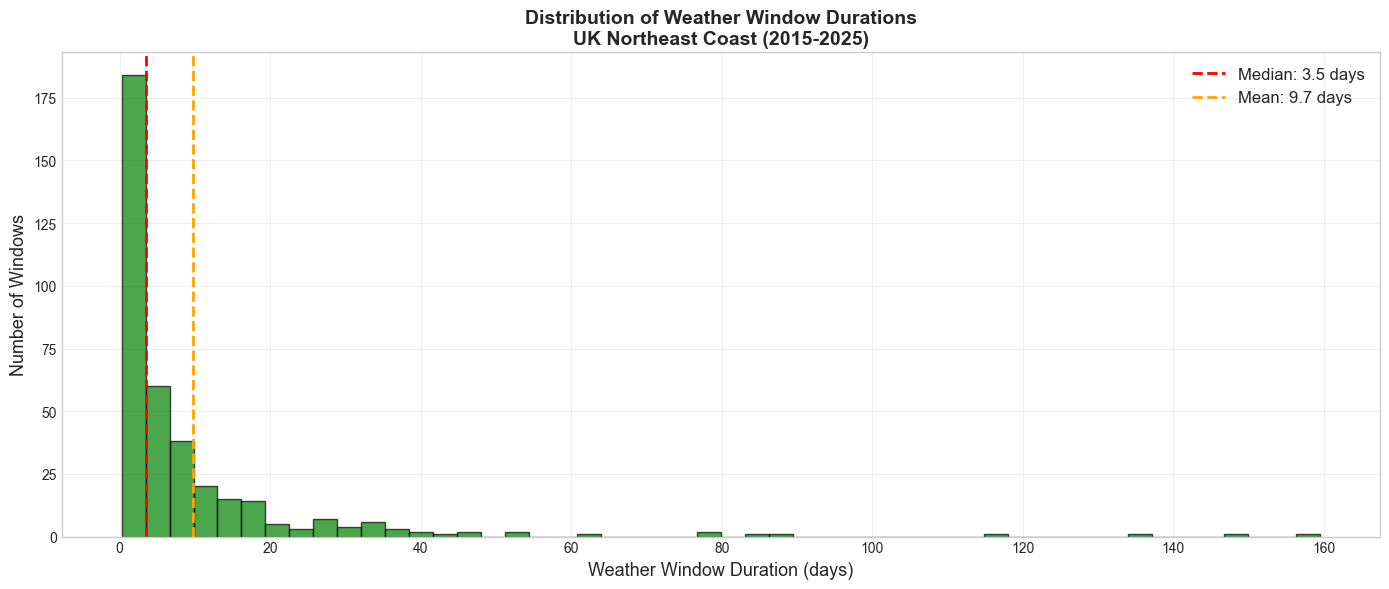

💡 Longer bars on the right = More extended weather windows = Better for operations!


In [4]:
# Visualize window distribution
fig, ax = plt.subplots(figsize=(14, 6))

ax.hist(window_days, bins=50, edgecolor='black', alpha=0.7, color='green')
ax.axvline(window_days.median(), color='red', linestyle='--', linewidth=2,
           label=f'Median: {window_days.median():.1f} days')
ax.axvline(window_days.mean(), color='orange', linestyle='--', linewidth=2,
           label=f'Mean: {window_days.mean():.1f} days')

ax.set_xlabel('Weather Window Duration (days)', fontsize=13)
ax.set_ylabel('Number of Windows', fontsize=13)
ax.set_title('Distribution of Weather Window Durations\nUK Northeast Coast (2015-2025)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Longer bars on the right = More extended weather windows = Better for operations!")

### 🎯 Enhancement #1 Verdict: **VERY VALUABLE!**

✅ **Add to Phase 2?** YES!
- Critical for operations needing consecutive days
- Easy to understand and visualize
- Highly requested by industry

---

## Part 3: Enhancement #2 - Wave Steepness 📐

**Question:** Are some waves worse than others at the same height?

In [5]:
print("=" * 80)
print("📐 WAVE STEEPNESS ANALYSIS")
print("=" * 80)

print("\n💡 Concept:")
print("  • Hs = 2m, Tp = 12s → Gentle long-period swell (EASY to work in)")
print("  • Hs = 2m, Tp = 5s  → Steep choppy seas (HARD to work in)")
print("  • Same height, different experience!\n")

# Calculate wavelength (deep water)
df_sorted['wavelength'] = 1.56 * df_sorted['tp']**2

# Calculate steepness
df_sorted['steepness'] = df_sorted['hs'] / df_sorted['wavelength']

print(f"📊 Steepness Statistics:")
print(f"  Mean: {df_sorted['steepness'].mean():.4f}")
print(f"  Median: {df_sorted['steepness'].median():.4f}")
print(f"  Max: {df_sorted['steepness'].max():.4f}")

# Classify
gentle = (df_sorted['steepness'] < 0.02).sum()
moderate = ((df_sorted['steepness'] >= 0.02) & (df_sorted['steepness'] < 0.04)).sum()
steep = (df_sorted['steepness'] >= 0.04).sum()
total = len(df_sorted)

print(f"\n📈 Sea State Classification:\n")
print(f"  🟢 Gentle (<0.02):      {gentle/total*100:5.1f}% of time")
print(f"  🟡 Moderate (0.02-0.04): {moderate/total*100:5.1f}% of time")
print(f"  🔴 Steep (>0.04):        {steep/total*100:5.1f}% of time")

print(f"\n💡 Impact on workability:")
print(f"  • Traditional limit: Hs < 2.5m = {(df_sorted['hs'] < 2.5).sum()/total*100:.1f}% workable")

# Add steepness criterion
smart_workability = ((df_sorted['hs'] < 2.5) & (df_sorted['steepness'] < 0.04)).sum()
print(f"  • Smart limit: Hs < 2.5m AND Steepness < 0.04 = {smart_workability/total*100:.1f}% workable")
print(f"  • Difference: {(df_sorted['hs'] < 2.5).sum()/total*100 - smart_workability/total*100:.1f}% points")
print(f"\n  → Steepness criterion is MORE restrictive (more realistic!)")

📐 WAVE STEEPNESS ANALYSIS

💡 Concept:
  • Hs = 2m, Tp = 12s → Gentle long-period swell (EASY to work in)
  • Hs = 2m, Tp = 5s  → Steep choppy seas (HARD to work in)
  • Same height, different experience!

📊 Steepness Statistics:
  Mean: 0.0210
  Median: 0.0194
  Max: 0.0642

📈 Sea State Classification:

  🟢 Gentle (<0.02):       51.2% of time
  🟡 Moderate (0.02-0.04):  43.3% of time
  🔴 Steep (>0.04):          5.4% of time

💡 Impact on workability:
  • Traditional limit: Hs < 2.5m = 91.7% workable
  • Smart limit: Hs < 2.5m AND Steepness < 0.04 = 87.2% workable
  • Difference: 4.4% points

  → Steepness criterion is MORE restrictive (more realistic!)


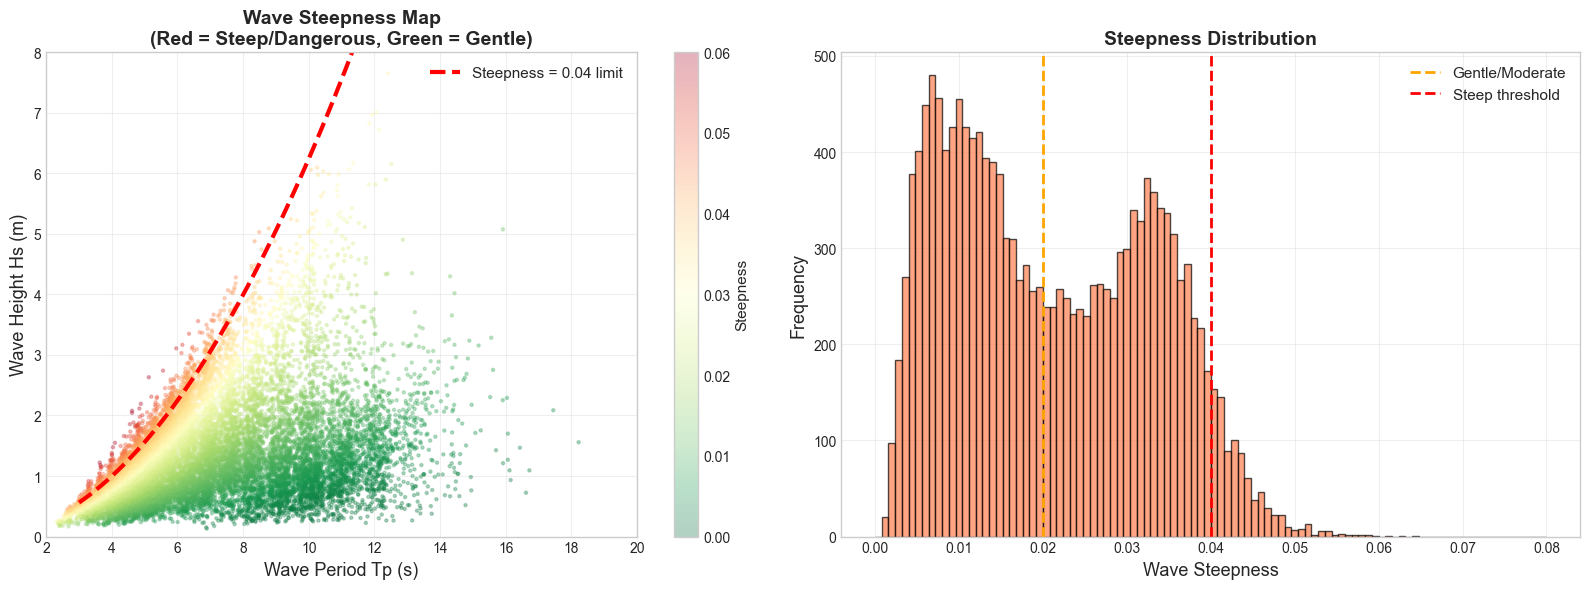


💡 Left plot: Points ABOVE red line are steep waves (more dangerous for vessels)


In [6]:
# Visualize steepness
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
scatter = axes[0].scatter(df_sorted['tp'], df_sorted['hs'], 
                         c=df_sorted['steepness'], cmap='RdYlGn_r',
                         s=5, alpha=0.3, vmin=0, vmax=0.06)
axes[0].set_xlabel('Wave Period Tp (s)', fontsize=13)
axes[0].set_ylabel('Wave Height Hs (m)', fontsize=13)
axes[0].set_title('Wave Steepness Map\n(Red = Steep/Dangerous, Green = Gentle)', 
                  fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Steepness', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Add steepness threshold line
tp_range = np.linspace(3, 20, 100)
hs_steep = 0.04 * 1.56 * tp_range**2
axes[0].plot(tp_range, hs_steep, 'r--', linewidth=3, label='Steepness = 0.04 limit')
axes[0].legend(fontsize=11)
axes[0].set_xlim(2, 20)
axes[0].set_ylim(0, 8)

# Histogram
axes[1].hist(df_sorted['steepness'], bins=100, edgecolor='black', 
             alpha=0.7, color='coral', range=(0, 0.08))
axes[1].axvline(0.02, color='orange', linestyle='--', linewidth=2, label='Gentle/Moderate')
axes[1].axvline(0.04, color='red', linestyle='--', linewidth=2, label='Steep threshold')
axes[1].set_xlabel('Wave Steepness', fontsize=13)
axes[1].set_ylabel('Frequency', fontsize=13)
axes[1].set_title('Steepness Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Left plot: Points ABOVE red line are steep waves (more dangerous for vessels)")

### 🎯 Enhancement #2 Verdict: **VERY USEFUL!**

✅ **Add to Phase 2?** YES!
- Easy to calculate
- More realistic than just Hs limits
- Accounts for wave period effects

---

## Part 4: Enhancement #3 - Year-Over-Year Trends 📅

**Question:** How much does workability vary between years?

In [7]:
print("=" * 80)
print("📅 YEAR-OVER-YEAR WORKABILITY ANALYSIS")
print("=" * 80)

# Add year
df_sorted['year'] = pd.to_datetime(df_sorted['time']).dt.year

# Exclude incomplete 2025
df_complete = df_sorted[df_sorted['year'] < 2025].copy()

max_hs = 2.5
max_wind = 15.0

print(f"\nOperation: Crane Heavy Lift (Hs<{max_hs}m, Wind<{max_wind}m/s)\n")

yearly_stats = []

for year in sorted(df_complete['year'].unique()):
    year_data = df_complete[df_complete['year'] == year]
    
    workable = ((year_data['hs'] < max_hs) & (year_data['wind_speed'] < max_wind)).sum()
    total = len(year_data)
    workability = (workable / total) * 100
    
    mean_hs = year_data['hs'].mean()
    
    yearly_stats.append({
        'year': year,
        'workability': workability,
        'mean_hs': mean_hs
    })
    
    print(f"  {year}: {workability:5.1f}% workable | Mean Hs: {mean_hs:.2f}m")

yearly_df = pd.DataFrame(yearly_stats)

print(f"\n📊 Variability Analysis:")
print(f"  Best year: {yearly_df.loc[yearly_df['workability'].idxmax(), 'year']:.0f} ({yearly_df['workability'].max():.1f}%)")
print(f"  Worst year: {yearly_df.loc[yearly_df['workability'].idxmin(), 'year']:.0f} ({yearly_df['workability'].min():.1f}%)")
print(f"  Range: {yearly_df['workability'].max() - yearly_df['workability'].min():.1f}% points")
print(f"  Average: {yearly_df['workability'].mean():.1f}%")
print(f"  Std deviation: {yearly_df['workability'].std():.1f}%")

print(f"\n💡 What this means:")
range_pct = yearly_df['workability'].max() - yearly_df['workability'].min()
if range_pct > 10:
    print(f"  • HIGH variability ({range_pct:.1f}% range)")
    print(f"  • Some years MUCH better than others")
    print(f"  • Always plan for worst-case year!")
elif range_pct > 5:
    print(f"  • MODERATE variability ({range_pct:.1f}% range)")
    print(f"  • Conditions fairly consistent")
else:
    print(f"  • LOW variability ({range_pct:.1f}% range)")
    print(f"  • Very consistent year-to-year")

📅 YEAR-OVER-YEAR WORKABILITY ANALYSIS

Operation: Crane Heavy Lift (Hs<2.5m, Wind<15.0m/s)

  2015:  91.5% workable | Mean Hs: 1.36m
  2016:  92.3% workable | Mean Hs: 1.34m
  2017:  90.3% workable | Mean Hs: 1.38m
  2018:  91.0% workable | Mean Hs: 1.34m
  2019:  92.5% workable | Mean Hs: 1.35m
  2020:  92.4% workable | Mean Hs: 1.35m
  2021:  90.3% workable | Mean Hs: 1.35m
  2022:  92.0% workable | Mean Hs: 1.35m
  2023:  92.5% workable | Mean Hs: 1.37m
  2024:  90.6% workable | Mean Hs: 1.36m

📊 Variability Analysis:
  Best year: 2019 (92.5%)
  Worst year: 2017 (90.3%)
  Range: 2.3% points
  Average: 91.5%
  Std deviation: 0.9%

💡 What this means:
  • LOW variability (2.3% range)
  • Very consistent year-to-year


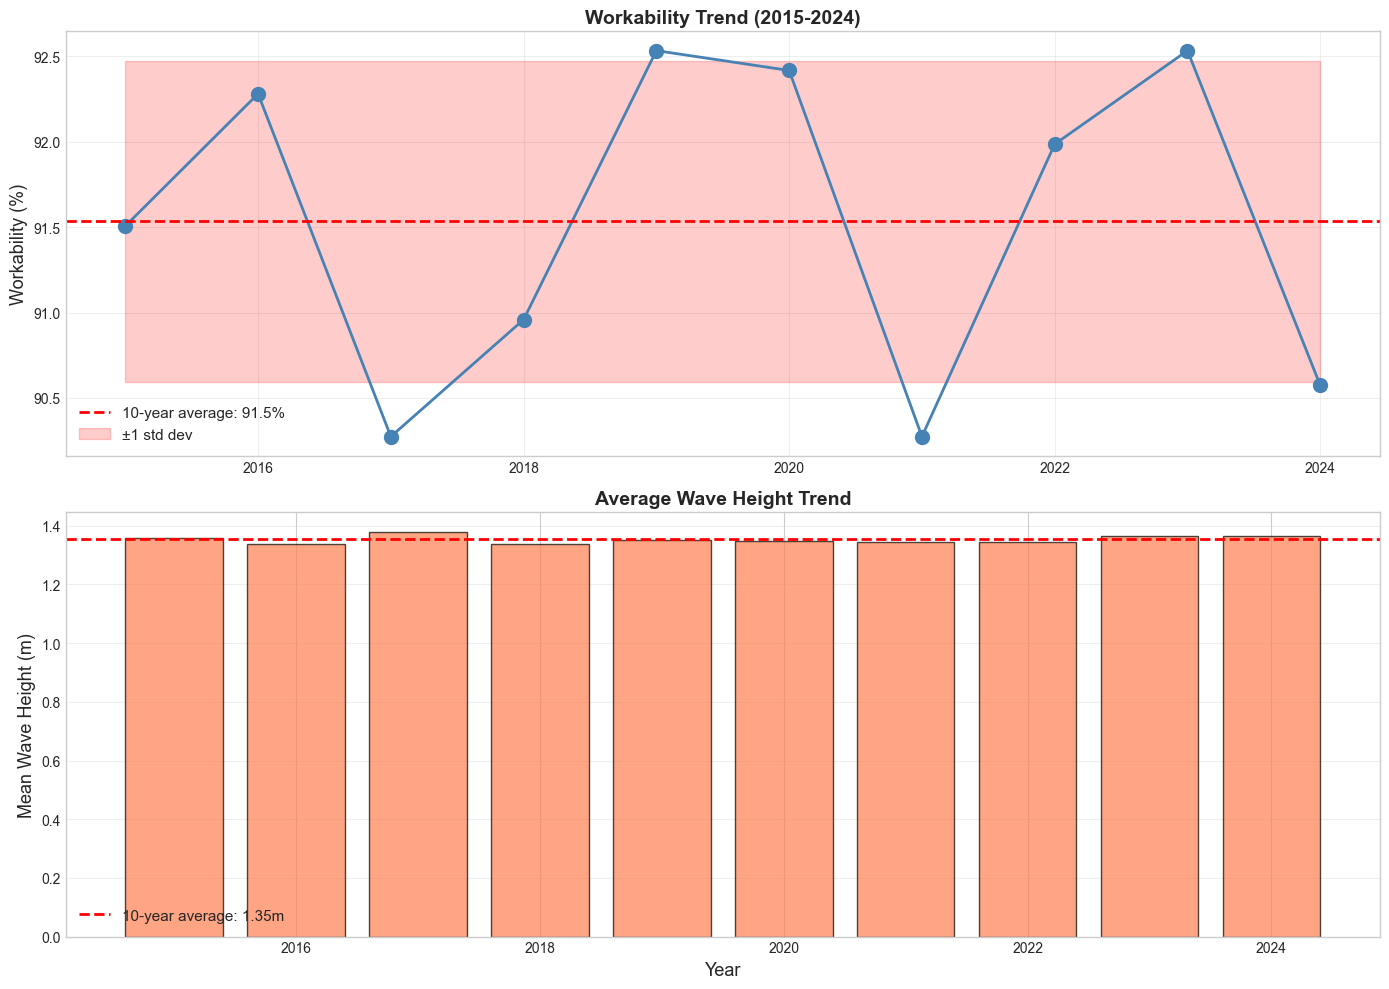


💡 If trend is increasing → Conditions worsening over time
   If trend is decreasing → Conditions improving
   If flat with variation → Normal inter-annual variability


In [8]:
# Visualize trends
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Workability trend
axes[0].plot(yearly_df['year'], yearly_df['workability'], 'o-', 
             linewidth=2, markersize=10, color='steelblue')
axes[0].axhline(yearly_df['workability'].mean(), color='red', 
                linestyle='--', linewidth=2, 
                label=f"10-year average: {yearly_df['workability'].mean():.1f}%")
axes[0].fill_between(yearly_df['year'], 
                      yearly_df['workability'].mean() - yearly_df['workability'].std(),
                      yearly_df['workability'].mean() + yearly_df['workability'].std(),
                      alpha=0.2, color='red', label='±1 std dev')
axes[0].set_ylabel('Workability (%)', fontsize=13)
axes[0].set_title('Workability Trend (2015-2024)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Mean wave height trend
axes[1].bar(yearly_df['year'], yearly_df['mean_hs'], 
            color='coral', alpha=0.7, edgecolor='black')
axes[1].axhline(yearly_df['mean_hs'].mean(), color='red', 
                linestyle='--', linewidth=2,
                label=f"10-year average: {yearly_df['mean_hs'].mean():.2f}m")
axes[1].set_xlabel('Year', fontsize=13)
axes[1].set_ylabel('Mean Wave Height (m)', fontsize=13)
axes[1].set_title('Average Wave Height Trend', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 If trend is increasing → Conditions worsening over time")
print("   If trend is decreasing → Conditions improving")
print("   If flat with variation → Normal inter-annual variability")

### 🎯 Enhancement #3 Verdict: **IMPORTANT FOR PLANNING!**

✅ **Add to Phase 2?** YES!
- Shows risk and uncertainty
- Important for multi-year projects
- Easy to calculate and visualize

---

## Part 5: Check for Directional Data 🧭

In [9]:
print("=" * 80)
print("🧭 DIRECTIONAL DATA CHECK")
print("=" * 80)

has_wave_dir = 'dir' in df.columns
has_wind_components = 'wind_u' in df.columns and 'wind_v' in df.columns

if has_wave_dir:
    print("\n✅ WAVE DIRECTION AVAILABLE!")
    print(f"   Range: {df['dir'].min():.1f}° to {df['dir'].max():.1f}°")
    print(f"   Mean: {df['dir'].mean():.1f}°")
    print("\n   → We CAN add directional workability!")
    
    # Quick direction distribution
    sectors = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    sector_bounds = [0, 45, 90, 135, 180, 225, 270, 315, 360]
    
    print("\n   Dominant wave directions:")
    for i, sector in enumerate(sectors):
        lower = sector_bounds[i]
        upper = sector_bounds[i+1]
        count = ((df['dir'] >= lower) & (df['dir'] < upper)).sum()
        pct = count / len(df) * 100
        if pct > 5:  # Only show significant sectors
            bar = '█' * int(pct / 2)
            print(f"   {sector:3s}: {pct:5.1f}% {bar}")
else:
    print("\n⚠️  Wave direction not in cleaned data")
    print("   (But might be in raw NetCDF files!)")

if has_wind_components:
    print("\n✅ WIND DIRECTION CAN BE CALCULATED!")
    wind_dir = (np.degrees(np.arctan2(-df['wind_u'], -df['wind_v'])) + 360) % 360
    print(f"   Range: {wind_dir.min():.1f}° to {wind_dir.max():.1f}°")
    print(f"   Mean: {wind_dir.mean():.1f}°")

print("\n" + "=" * 80)

🧭 DIRECTIONAL DATA CHECK

✅ WAVE DIRECTION AVAILABLE!
   Range: 0.0° to 360.0°
   Mean: 163.8°

   → We CAN add directional workability!

   Dominant wave directions:
   N  :  23.5% ███████████
   NE :  12.1% ██████
   E  :   9.6% ████
   SE :  10.8% █████
   S  :   9.1% ████
   SW :   9.4% ████
   W  :   9.7% ████
   NW :  15.8% ███████

✅ WIND DIRECTION CAN BE CALCULATED!
   Range: 0.0° to 360.0°
   Mean: 201.9°



---
## Part 6: Summary - What Should We Add to Phase 2?

In [10]:
print("=" * 80)
print("🎯 FINAL RECOMMENDATIONS")
print("=" * 80)

print("\n✅ TOP 3 ENHANCEMENTS TO ADD TO PHASE 2:\n")

print("1️⃣  WEATHER WINDOWS")
print("   Why: Most requested by industry")
print("   Value: Critical for operations needing consecutive days")
print("   Difficulty: ⭐⭐ Moderate")
print(f"   Your data: {len(window_days)} windows found! ✅\n")

print("2️⃣  WAVE STEEPNESS CRITERIA")
print("   Why: More realistic than just Hs limits")
print("   Value: Accounts for wave period effects")
print("   Difficulty: ⭐ Easy")
print(f"   Your data: {steep} steep conditions identified ✅\n")

print("3️⃣  YEAR-OVER-YEAR VARIABILITY")
print("   Why: Shows risk and uncertainty")
print("   Value: Essential for multi-year planning")
print("   Difficulty: ⭐ Easy")
print(f"   Your data: {yearly_df['workability'].max() - yearly_df['workability'].min():.1f}% variation found! ✅\n")

if has_wave_dir:
    print("BONUS: 4️⃣  DIRECTIONAL WORKABILITY")
    print("   Why: Some ops have directional limits")
    print("   Value: More accurate for beam sea restrictions")
    print("   Difficulty: ⭐⭐ Moderate")
    print("   Your data: Wave direction available! ✅\n")

print("\n" + "=" * 80)
print("NEXT STEP: Implement these 3 enhancements in Phase 2!")
print("=" * 80)

print("\n🚀 Ready to upgrade your Phase 2 notebook?")
print("   These additions will make it industry-grade! 💪")

🎯 FINAL RECOMMENDATIONS

✅ TOP 3 ENHANCEMENTS TO ADD TO PHASE 2:

1️⃣  WEATHER WINDOWS
   Why: Most requested by industry
   Value: Critical for operations needing consecutive days
   Difficulty: ⭐⭐ Moderate
   Your data: 375 windows found! ✅

2️⃣  WAVE STEEPNESS CRITERIA
   Why: More realistic than just Hs limits
   Value: Accounts for wave period effects
   Difficulty: ⭐ Easy
   Your data: 864 steep conditions identified ✅

3️⃣  YEAR-OVER-YEAR VARIABILITY
   Why: Shows risk and uncertainty
   Value: Essential for multi-year planning
   Difficulty: ⭐ Easy
   Your data: 2.3% variation found! ✅

BONUS: 4️⃣  DIRECTIONAL WORKABILITY
   Why: Some ops have directional limits
   Value: More accurate for beam sea restrictions
   Difficulty: ⭐⭐ Moderate
   Your data: Wave direction available! ✅


NEXT STEP: Implement these 3 enhancements in Phase 2!

🚀 Ready to upgrade your Phase 2 notebook?
   These additions will make it industry-grade! 💪


---
## 🎓 Congratulations!

You've discovered what's possible with your Phase 1 data!

**Key findings:**
- ✅ Weather windows analysis is ready
- ✅ Wave steepness can be calculated
- ✅ Year-over-year trends show variability
- ✅ (Bonus) Directional data may be available

**Next:** Let's implement these in an enhanced Phase 2 notebook! 🚀